**Limitations**
All of these analyses have to be taken with a grain of salt, as I noticed that engine evaluation oscillates for some positions as depth increases (SF 14+NNUE on lichess) and depth 20 isn't deep enough at all for a very accurate assessment. Of course, it also depends on engine config
So, we get a rough idea which setups favour which side, but these are not exact evaluations. I have seen them differ as much as 40 centipawns. That shouldn't turn clearly drawn positions into clear wins or vice versa, but may be relevant for not-so-clear cases.

In [ ]:
# Get the data here: https://tcec-chess.com/misc/dfrc/DFRC_depth20.csv.xz
# Thanks to TCEC for providing this data

In [1]:
import pandas as pd

In [2]:
# TODO: pawns only defended by the king (or queen) might also be considered weaknesses (cf f7 in standard chess)
def n_undefended_pawns(pos):
    pos = pos.lower()
    pawns = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    i = 2
    while i < 10:
        if (pos[i-2] == 'b'):
            pawns[i-1] = 0
            pawns[i+1] = 0
        if (pos[i-2] == 'r'):
            pawns[i] = 0
        if (pos[i-2] == 'n'):
            pawns[i-2] = 0
            pawns[i+2] = 0
        if (pos[i-2] == 'k' or pos[i-2] == 'q'):
            pawns[i-1] = 0
            pawns[i+1] = 0
            pawns[i] = 0
        i+=1

    return sum(pawns[2:10]), pawns[2:10]

def extract_white_pos(fen):
    pos = ''
    i = 0
    tmp = [char for char in fen if char.isupper() and char != 'P']
    for char in tmp:
        if (i >= 8):
            break
        pos += char
        i+=1
    return pos

In [3]:
evals_table = pd.read_csv('DFRC_depth20.csv.xz', compression = 'xz', delimiter = '\t')
evals_table.rename(columns={'Eval (white)': 'eval'}, inplace=True)
evals_table['WPOS'] = evals_table['FEN'].apply(extract_white_pos)
evals_table['BPOS'] = evals_table['FEN'].apply(lambda fen: fen[0:8])
evals_table.drop(['#', 'Opening'], axis=1, inplace=True)
evals_table['nWweakn'] = evals_table['WPOS'].apply(lambda x: n_undefended_pawns(x)[0])
evals_table['nBweakn'] = evals_table['BPOS'].apply(lambda x: n_undefended_pawns(x)[0])

chess960 = evals_table.loc[evals_table['WPOS'] == evals_table['BPOS'].apply(lambda x: x.upper())]

In [4]:
evals_table['eval'].describe()

count    921600.000000
mean         50.583815
std          69.553135
min        -243.000000
25%           2.000000
50%          50.000000
75%          97.000000
max         359.000000
Name: eval, dtype: float64

<AxesSubplot:ylabel='Frequency'>

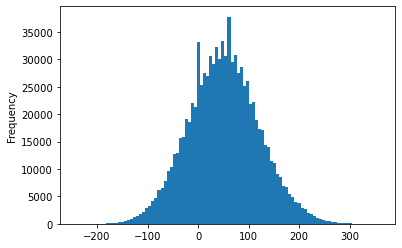

In [8]:
evals_table['eval'].plot.hist(bins=100)

In [24]:
# just out of curiosity
evals_table['Time'].sum() / 60 / 60 / 24

37.07039405092595

### White's most robust setups (where Black is allowed to choose a rule-compliant setup) 

In [25]:
cols_1 = ['FEN', 'eval', 'W', 'D', 'L', 'Time', 'Nodes', 'Depth', 'PV']

In [26]:
evals_table.loc[evals_table.groupby('WPOS')['eval'].idxmin()].sort_values(by=['eval'], ascending=False)[cols_1]

FEN  eval   W    D    L  \
370000  bbrqnnkr/pppppppp/8/8/8/8/PPPPPPPP/BQRBNNKR w ...    23  66  908   26   
732482  bqnnrbkr/pppppppp/8/8/8/8/PPPPPPPP/RKNNBRQB w ...    20  62  911   27   
725200  bbrqnnkr/pppppppp/8/8/8/8/PPPPPPPP/BRKNNRQB w ...    11  52  915   33   
384855  rkbnrnqb/pppppppp/8/8/8/8/PPPPPPPP/BBRQNNKR w ...     8  49  916   35   
369025  bqrbnnkr/pppppppp/8/8/8/8/PPPPPPPP/BBQRNNKR w ...     2  44  917   39   
...                                                   ...   ...  ..  ...  ...   
240400  bbrqnnkr/pppppppp/8/8/8/8/PPPPPPPP/NRKQBBNR w ...  -218   0  191  809   
243726  rknrqbbn/pppppppp/8/8/8/8/PPPPPPPP/NRKBQNBR w ...  -219   0  188  812   
362322  brqnnbkr/pppppppp/8/8/8/8/PPPPPPPP/NRKBBRNQ w ...  -222   0  179  821   
593396  nbbqrnkr/pppppppp/8/8/8/8/PPPPPPPP/RNQKBBRN w ...  -236   0  138  862   
578036  nbbqrnkr/pppppppp/8/8/8/8/PPPPPPPP/RQNKBBRN w ...  -243   0  122  878   

         Time    Nodes  Depth  \
370000  1.267   488385     20   
732482  3.618  1888082     20   
725200  6.684  2751701     20   
384855  2.559  1237486     20   
369025  2.260  1032009     20   
...       ...      ...    ...   
240400  2.768  1317988     20   
243726  6.695  3148781     20   
362322  5.604  2146366     20   
593396  5.218  1864487     20   
578036  7.118  2840454     20   

                                                       PV  
370000  1. c4 c5 2. e3 b6 3. h4 h5 4. b3 Ng6 5. Bf3 Bx...  
732482  1. a4 b6 2. f4 h5 3. d3 e6 4. e4 d5 5. g3 c5 6...  
725200  1. g3 d5 2. e4 b5 3. exd5 Bxd5 4. Bxd5 Qxd5 5....  
384855  1. b4 a5 2. b5 g6 3. d4 d6 4. c4 Nd7 5. Nd3 b6...  
369025  1. h4 h5 2. d4 b5 3. b3 c5 4. dxc5 Rxc5 5. Rh3...  
...                                                   ...  
240400  1. c3 c5 2. f3 b5 3. e4 d5 4. Bxb5 dxe4 5. Ba6...  
243726  1. f4 f6 2. a4 a5 3. c3 e5 4. fxe5 fxe5 5. Bb3...  
362322  1. e3 c5 2. f4 b5 3. Bf3 h5 4. Bxa8 Rxa8 5. Nf...  
593396  1. f3 d5 2. d3 h5 3. Nf2 c5 4. g3 h4 5. a4 Nc7...  
578036  1. f3 d5 2. Bf2 c5 3. g3 Bd6 4. Bg2 h5 5. f4 h...  

[960 rows x 9 columns]

Average and median black advantage when Black gets to choose his setup

In [27]:
evals_table.loc[evals_table.groupby('WPOS')['eval'].idxmin()]['eval'].describe()

count    960.000000
mean    -109.157292
std       44.881576
min     -243.000000
25%     -139.000000
50%     -110.000000
75%      -77.000000
max       23.000000
Name: eval, dtype: float64

Summary statistics for the most robust White setups

In [28]:
evals_table.loc[evals_table['WPOS'] == 'BQRBNNKR']['eval'].describe()

count    960.000000
mean     177.145833
std       57.498457
min       23.000000
25%      136.000000
50%      173.000000
75%      217.000000
max      337.000000
Name: eval, dtype: float64

In [29]:
evals_table.loc[evals_table['WPOS'] == 'RKNNBRQB']['eval'].describe()

count    960.000000
mean     162.088542
std       53.352503
min       20.000000
25%      126.000000
50%      157.000000
75%      200.000000
max      337.000000
Name: eval, dtype: float64

### Black's best setup(s) against White's standard setup

In [30]:
evals_table.loc[evals_table['WPOS'] == 'RNBQKBNR'].sort_values(by=['eval'], ascending=True)[cols_1]

FEN  eval    W    D  \
497600  bbnrqkrn/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...  -108    4  701   
497408  bbnrqnkr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...  -107    4  703   
497664  bbqrnnkr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...  -106    5  708   
498047  rknnrqbb/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...  -101    5  726   
497856  bbqrnkrn/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...   -96    6  746   
...                                                   ...   ...  ...  ...   
497786  rqnkbbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...   163  573  426   
497978  rqknbbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...   166  590  409   
497653  nrbbkrnq/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...   168  600  399   
497974  rqbknbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...   174  628  371   
498167  rqbkrnnb/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...   178  649  350   

          L   Time    Nodes  Depth  \
497600  295  3.676  1816676     20   
497408  293  5.453  2728937     20   
497664  287  3.885  1690028     20   
498047  269  4.977  2242905     20   
497856  248  2.267  1123931     20   
...     ...    ...      ...    ...   
497786    1  2.349   894737     20   
497978    1  2.256   910305     20   
497653    1  2.544  1217185     20   
497974    1  3.029  1429593     20   
498167    1  1.404   724868     20   

                                                       PV  
497600  1. e3 b6 2. d4 c5 3. d5 O-O 4. c4 e6 5. Nf3 b5...  
497408  1. d4 b6 2. e3 d5 3. f4 Nd6 4. a4 Nd7 5. a5 b5...  
497664  1. a4 b6 2. d4 Ng6 3. Nf3 Nf6 4. Bg5 Ne4 5. e3...  
498047  1. Nf3 e5 2. d3 f5 3. e3 e4 4. Nd4 g5 5. Be2 N...  
497856  1. Nf3 O-O 2. c4 b6 3. g3 Ng6 4. Nc3 Ne5 5. e4...  
...                                                   ...  
497786  1. e4 c5 2. Nf3 f6 3. Be2 e6 4. d4 Bg6 5. Nc3 ...  
497978  1. Nf3 c6 2. d4 f6 3. c4 e5 4. d5 Nf7 5. e4 f5...  
497653  1. e4 d6 2. d4 c6 3. a4 Nf6 4. Bd3 O-O 5. Nf3 ...  
497974  1. e4 e6 2. d4 d5 3. e5 c5 4. c3 h6 5. Nf3 b6 ...  
498167  1. d4 e5 2. dxe5 Rxe5 3. Nf3 Re7 4. Nc3 Nf6 5....  

[960 rows x 9 columns]

In [31]:
evals_table.loc[evals_table['WPOS'] == 'RNBQKBNR']['eval'].describe()

count    960.000000
mean      31.466667
std       52.248274
min     -108.000000
25%        0.000000
50%       31.000000
75%       66.250000
max      178.000000
Name: eval, dtype: float64

### Black's best setup(s) against the setup White would choose if White could choose the setup for both players
(i.e. against White's setup in the worst starting position for Black)

In [32]:
evals_table.loc[evals_table['WPOS'] == 'BQRNNKRB'].sort_values(by=['eval'], ascending=True)[cols_1]

FEN  eval    W    D   L  \
371580  nbnrqkbr/pppppppp/8/8/8/8/PPPPPPPP/BQRNNKRB w ...     1   43  917  40   
371636  nbbqrnkr/pppppppp/8/8/8/8/PPPPPPPP/BQRNNKRB w ...     7   48  917  35   
371828  nbbqrkrn/pppppppp/8/8/8/8/PPPPPPPP/BQRNNKRB w ...     7   48  916  36   
371748  nbbrqknr/pppppppp/8/8/8/8/PPPPPPPP/BQRNNKRB w ...    20   62  911  27   
371844  nbbrqkrn/pppppppp/8/8/8/8/PPPPPPPP/BQRNNKRB w ...    22   65  909  26   
...                                                   ...   ...  ...  ...  ..   
371994  rnnkbbrq/pppppppp/8/8/8/8/PPPPPPPP/BQRNNKRB w ...   323  975   25   0   
371586  bnnrkbqr/pppppppp/8/8/8/8/PPPPPPPP/BQRNNKRB w ...   323  975   25   0   
372393  qrkbbrnn/pppppppp/8/8/8/8/PPPPPPPP/BQRNNKRB w ...   337  981   19   0   
372399  qrkrnnbb/pppppppp/8/8/8/8/PPPPPPPP/BQRNNKRB w ...   350  986   14   0   
372394  qrkrbbnn/pppppppp/8/8/8/8/PPPPPPPP/BQRNNKRB w ...   359  988   12   0   

         Time    Nodes  Depth  \
371580  3.480  1841252     20   
371636  1.895   957616     20   
371828  3.776  1404699     20   
371748  2.923  1257734     20   
371844  2.473  1070131     20   
...       ...      ...    ...   
371994  2.898  1203359     20   
371586  2.354  1280180     20   
372393  4.916  2250194     20   
372399  2.559   971040     20   
372394  3.968  1563030     20   

                                                       PV  
371580  1. g3 d5 2. c4 c6 3. b3 f6 4. f4 Bf7 5. Nf3 O-...  
371636  1. c4 c6 2. g3 d5 3. cxd5 cxd5 4. b3 e5 5. Rxc...  
371828  1. g3 c6 2. b3 O-O 3. c4 d5 4. d4 Bh3+ 5. Bg2 ...  
371748  1. c4 c6 2. g3 d5 3. cxd5 cxd5 4. b3 Nf6 5. Nf...  
371844  1. c4 O-O 2. g3 c6 3. O-O d5 4. cxd5 cxd5 5. b...  
...                                                   ...  
371994  1. b4 f6 2. g3 c6 3. c4 Bg6 4. Nd3 e5 5. c5 Na...  
371586  1. g4 c6 2. c4 g6 3. b4 Bg7 4. Ne3 Bxa1 5. Qxa...  
372393  1. c4 f5 2. b3 Nf6 3. Qxf5 Bg6 4. Qc5 Be4 5. Q...  
372399  1. b4 d5 2. g3 f6 3. c4 g6 4. O-O d4 5. e3 e5 ...  
372394  1. c4 Ng6 2. b4 e6 3. g3 a6 4. O-O Qa7 5. Ne3 ...  

[960 rows x 9 columns]

In [33]:
evals_table.loc[evals_table['WPOS'] == 'BQRNNKRB'].sort_values(by=['eval'], ascending=True).iloc[1]["FEN"]

'nbbqrnkr/pppppppp/8/8/8/8/PPPPPPPP/BQRNNKRB w KQkq - 0 1'

According my local lichess-Stockfish 14, this is better for Black than the first entry..

### White advantage when Black decides on White's setup first and White decides on Black's setup

In [34]:
evals_table.loc[evals_table.groupby('WPOS')['eval'].idxmax()].sort_values(by=['eval'], ascending=True)[cols_1]

FEN  eval    W    D  L  \
358774  rqbknbnr/pppppppp/8/8/8/8/PPPPPPPP/NRBBKRNQ w ...    75  174  817  9   
635066  rqnkbbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBBKRNQ w ...    81  192  800  8   
317699  brkqrnnb/pppppppp/8/8/8/8/PPPPPPPP/NRQKBBRN w ...    82  197  795  8   
332533  nrbbkrnq/pppppppp/8/8/8/8/PPPPPPPP/NRKQBBRN w ...    87  214  779  7   
451657  rnnbbkqr/pppppppp/8/8/8/8/PPPPPPPP/RNBNKBRQ w ...    93  235  759  6   
...                                                   ...   ...  ...  ... ..   
37083   rqnkbrnb/pppppppp/8/8/8/8/PPPPPPPP/NNBQRBKR w ...   340  982   18  0   
92319   nrnqkrbb/pppppppp/8/8/8/8/PPPPPPPP/BBQNRNKR w ...   343  983   17  0   
737120  bbrkqnrn/pppppppp/8/8/8/8/PPPPPPPP/RKNNRQBB w ...   350  986   14  0   
368799  nrnqkrbb/pppppppp/8/8/8/8/PPPPPPPP/BBQRNNKR w ...   351  986   14  0   
372394  qrkrbbnn/pppppppp/8/8/8/8/PPPPPPPP/BQRNNKRB w ...   359  988   12  0   

         Time    Nodes  Depth  \
358774  4.864  2102748     20   
635066  2.229  1208740     20   
317699  3.687  1646038     20   
332533  1.985   878929     20   
451657  2.907  1274553     20   
...       ...      ...    ...   
37083   2.067   904787     20   
92319   3.262  1299197     20   
737120  4.345  2113328     20   
368799  4.400  1797237     20   
372394  3.968  1563030     20   

                                                       PV  
358774  1. Nf3 f6 2. O-O e5 3. e4 b6 4. d4 exd4 5. Nxd...  
635066  1. Nf3 f6 2. d4 c5 3. O-O cxd4 4. c3 dxc3 5. N...  
317699  1. b4 b6 2. Qa3 g6 3. e3 Bb7 4. f3 e5 5. Bg3 e...  
332533  1. g4 c6 2. e3 Bc7 3. Ng3 d6 4. d4 g6 5. a4 Bd...  
451657  1. Nbc3 c6 2. g4 f6 3. g5 d5 4. gxf6 exf6 5. b...  
...                                                   ...  
37083   1. e4 g6 2. d4 d6 3. h4 e5 4. dxe5 Bxe5 5. Rh3...  
92319   1. b3 b5 2. h4 c5 3. h5 Qc7 4. Nde3 Nab6 5. c4...  
737120  1. g3 g5 2. a4 Ne6 3. e3 f5 4. f4 c5 5. a5 Nf7...  
368799  1. b3 b5 2. h4 c5 3. h5 Nc7 4. Ne3 d5 5. c4 bx...  
372394  1. c4 Ng6 2. b4 e6 3. g3 a6 4. O-O Qa7 5. Ne3 ...  

[960 rows x 9 columns]

### White advantage when White decides on Black's setup first and Black decides on Whites's setup

In [35]:
evals_table.loc[evals_table.groupby('BPOS')['eval'].idxmin()].sort_values(by=['eval'], ascending=False)[cols_1]

FEN  eval   W    D    L  \
579253  nrbbkrnq/pppppppp/8/8/8/8/PPPPPPPP/RQNKBRNB w ...    27  71  905   24   
358410  nrqkbbrn/pppppppp/8/8/8/8/PPPPPPPP/NRBBKRNQ w ...    27  72  905   23   
358342  nrbknbqr/pppppppp/8/8/8/8/PPPPPPPP/NRBBKRNQ w ...    14  56  913   31   
891674  rqknbbrn/pppppppp/8/8/8/8/PPPPPPPP/BBRKRNQN w ...    10  51  916   33   
634906  nrkqbbrn/pppppppp/8/8/8/8/PPPPPPPP/RNBBKRNQ w ...     8  49  916   35   
...                                                   ...   ...  ..  ...  ...   
362322  brqnnbkr/pppppppp/8/8/8/8/PPPPPPPP/NRKBBRNQ w ...  -222   0  179  821   
578320  bbrqnnkr/pppppppp/8/8/8/8/PPPPPPPP/RQNKBBRN w ...  -224   0  173  827   
593665  bqrbnnkr/pppppppp/8/8/8/8/PPPPPPPP/RNQKBBRN w ...  -225   0  167  833   
593412  nbbrqnkr/pppppppp/8/8/8/8/PPPPPPPP/RNQKBBRN w ...  -227   0  162  838   
578036  nbbqrnkr/pppppppp/8/8/8/8/PPPPPPPP/RQNKBBRN w ...  -243   0  122  878   

         Time    Nodes  Depth  \
579253  2.919  1365267     20   
358410  4.586  1869734     20   
358342  2.678  1161914     20   
891674  3.925  1872125     20   
634906  5.531  2226161     20   
...       ...      ...    ...   
362322  5.604  2146366     20   
578320  3.576  1730777     20   
593665  5.099  2123513     20   
593412  2.585  1196191     20   
578036  7.118  2840454     20   

                                                       PV  
579253  1. f4 Nf6 2. h3 c6 3. g4 d5 4. a4 O-O 5. Qa2 B...  
358410  1. c4 f6 2. Bc2 g6 3. d3 Bf7 4. Nb3 c5 5. h4 b...  
358342  1. f4 f5 2. b3 g6 3. Nf3 c5 4. Qg1 d6 5. c4 Bg...  
891674  1. f4 e6 2. c4 Ng6 3. f5 exf5 4. Qf2 f4 5. b3 ...  
634906  1. d4 e6 2. c4 Nb6 3. Bb3 d5 4. c5 Nc4 5. Bc2 ...  
...                                                   ...  
362322  1. e3 c5 2. f4 b5 3. Bf3 h5 4. Bxa8 Rxa8 5. Nf...  
578320  1. f3 h5 2. e4 c5 3. Bg3 Bxg3 4. hxg3 c4 5. a4...  
593665  1. f3 b5 2. e4 h5 3. d4 c5 4. dxc5 Ne6 5. Qd2 ...  
593412  1. g3 d5 2. d3 e5 3. Bg2 c6 4. Bc3 Nc7 5. O-O ...  
578036  1. f3 d5 2. Bf2 c5 3. g3 Bd6 4. Bg2 h5 5. f4 h...  

[960 rows x 9 columns]

### TODO: Investigate, what happens, when both players setup their pieces alternating

1) being allowed to set opponents pieces (exclusively opponents, or both, or White only allowed to set a Black piece when Black sets a White piece, ...)

2) setting two pieces at one time (one own piece, one opponent piece)

3) setting only half the pieces in this manner and allowing each player to complete their setup

4) both players decide on their setup first independently without knowing the other's setup (concealed setup; will White play it safe and choose a robust setup, or will he trap Black into choosing his best setup against White's robust setup and choose a setup effective against this Black setup?)

5) the first three ranks can be used, instead of only the first two

6) Rooks can be anywhere, but if the king isn't between the rooks, no castling is allowed (it's probably good to have the flexibility to castle both ways, but having the king safe already may also be an asset)

7) ...

this way, if Black starts the setup process, but White gets the first move in return, Black may be able to avoid positions that are too good for White. Together with the next todo, there could evolve a new theory of chess for the first phase (the setup phase) with setup principles (queen in the middle) etc. 

The resulting game should be simple. Chess960 already has a hard time gaining traction (it's uneasy to get a 'normal' position, people love their openings and influence on the type of game they have with that).

### TODO: Find patterns in good setups

e.g. queen wants to be centralised, bishops want to be together in a korner, king wants to be able to castle immediately, king wants to be surrounded by knights, ...

**no undefended pawns**

--> then investigate how the engine would play these setups
--> revisit opening principles

#### TODO: Read about suggestions regarding Chess960 and predecessors in alternative setups, e.g. Brunner-Freischach

Edward Northam empfahl folgendes Vorgehen, um die Eröffnungsposition [Chess960] zufallsfrei zu erzeugen:

Könige und Türme werden zunächst aussortiert.
Die Spieler – Schwarz zuerst – nehmen abwechselnd nach Belieben eine ihrer Figuren und stellen sie auf einen freien Platz. Der Gegner stellt dann eine gleichartige Figur auf seiner Seite spiegelbildlich auf, bevor er an der Reihe ist, eine seiner Figuren frei zu platzieren. Dabei gilt wie üblich die Einschränkung, dass der zweite Läufer nicht auf derselben Feldfarbe aufgestellt werden darf wie der erste.
Nachdem so die Damen, Läufer und Springer platziert worden sind, wird der König auf das mittlere der noch freien Felder gesetzt und die Türme auf die übrigen beiden.
Mit diesem Verfahren wird der Aufbau der Figuren zu einem Teil der Partie. Ein Vorläufer davon ist das Freischach, das von Erich Brunner 1921 entwickelt wurde.

https://de.wikipedia.org/wiki/Erich_Brunner


"I tried many different starting positions and all these were somehow very unharmonious. And this is not surprising as in many of these positions there is immediate forced play: the pieces are placed so badly at the start that there is a need to improve their positions in one way only, which decreases the number of choices." — Vladimir Kramnik[82] [translated from Russian]

"Fischer Random is an interesting format, but it has its drawbacks. In particular, the nontraditional starting positions make it difficult for many amateurs to enjoy the game until more familiar positions are achieved. The same is true for world-class players, as many have confessed to me privately. Finally, it also seems to lack an aesthetic quality found in traditional chess, which makes it less appealing for both players and viewers, even if it does occasionally result in an exciting game." — Vladimir Kramnik[89]

## Positions without undefended pawns
first, we'll analyze their number, then we can investigate how their position influences evaluation

In [45]:
evals_table.groupby('nWweakn')['eval'].describe()

count       mean        std    min   25%   50%    75%    max
nWweakn                                                                 
0        345600.0  54.576389  69.572659 -203.0   6.0  53.0  100.0  343.0
1        433920.0  48.068441  69.796061 -243.0   0.0  47.0   94.0  351.0
2        138240.0  48.102481  68.531522 -219.0   0.0  48.0   93.0  359.0
3          3840.0  64.817448  57.235558 -111.0  27.0  63.0  102.0  269.0

In [44]:
evals_table.groupby('nBweakn')['eval'].describe()

count       mean        std    min  25%   50%    75%    max
nBweakn                                                                
0        345600.0  46.148177  69.084193 -243.0  0.0  46.0   92.0  351.0
1        433920.0  52.959405  69.969049 -222.0  4.0  52.0   99.0  359.0
2        138240.0  54.432762  69.049393 -197.0  6.0  53.0  100.0  337.0
3          3840.0  42.787500  60.381363 -147.0  0.0  40.0   83.0  240.0

In [38]:
evals_table.loc[evals_table['nWweakn'] == 3]

FEN  eval    W    D   L  \
56640   bbqnnrkr/pppppppp/8/8/8/8/PPPPPPPP/NNRQBKRB w ...    26   71  905  24   
56641   bqnbnrkr/pppppppp/8/8/8/8/PPPPPPPP/NNRQBKRB w ...    11   52  915  33   
56642   bqnnrbkr/pppppppp/8/8/8/8/PPPPPPPP/NNRQBKRB w ...   -41   18  889  93   
56643   bqnnrkrb/pppppppp/8/8/8/8/PPPPPPPP/NNRQBKRB w ...     6   47  917  36   
56644   qbbnnrkr/pppppppp/8/8/8/8/PPPPPPPP/NNRQBKRB w ...    -3   38  917  45   
...                                                   ...   ...  ...  ...  ..   
862075  rkrnbnqb/pppppppp/8/8/8/8/PPPPPPPP/BRKBQRNN w ...     3   44  917  39   
862076  rbkrnnbq/pppppppp/8/8/8/8/PPPPPPPP/BRKBQRNN w ...    57  126  861  13   
862077  rkrbnnbq/pppppppp/8/8/8/8/PPPPPPPP/BRKBQRNN w ...    88  219  774   7   
862078  rkrnnbbq/pppppppp/8/8/8/8/PPPPPPPP/BRKBQRNN w ...     2   43  918  39   
862079  rkrnnqbb/pppppppp/8/8/8/8/PPPPPPPP/BRKBQRNN w ...    27   72  905  23   

         Time    Nodes  Depth  \
56640   3.026  1128818     20   
56641   2.863  1119746     20   
56642   3.923  1691460     20   
56643   1.920   835710     20   
56644   3.463  1477402     20   
...       ...      ...    ...   
862075  1.840   959624     20   
862076  1.659   747724     20   
862077  4.129  1868625     20   
862078  4.221  1683360     20   
862079  2.114   858021     20   

                                                       PV      WPOS      BPOS  \
56640   1. g3 c6 2. d4 b6 3. c4 h5 4. Bb4 d6 5. Qd3 Bb...  NNRQBKRB  bbqnnrkr   
56641   1. g3 b6 2. Bxa8 Qxa8 3. d4 f5 4. c4 Rf7 5. Nb...  NNRQBKRB  bqnbnrkr   
56642   1. c4 e5 2. g3 h5 3. Nb3 b6 4. Bxa8 Qxa8 5. d4...  NNRQBKRB  bqnnrbkr   
56643   1. g3 g6 2. d4 b5 3. Bxa8 Qxa8 4. Na3 a6 5. c4...  NNRQBKRB  bqnnrkrb   
56644   1. c4 c6 2. g3 d5 3. cxd5 Bh3+ 4. Bg2 Bxg2+ 5....  NNRQBKRB  qbbnnrkr   
...                                                   ...       ...       ...   
862075  1. b3 a5 2. e4 a4 3. Qe3 g6 4. Bxh8 Qxh8 5. d4...  BRKBQRNN  rkrnbnqb   
862076  1. b3 f6 2. f4 c6 3. e4 a5 4. a4 Bd6 5. e5 Ba3...  BRKBQRNN  rbkrnnbq   
862077  1. f4 f6 2. b3 c6 3. e4 Bb6 4. e5 Bd5 5. Bf3 N...  BRKBQRNN  rkrbnnbq   
862078  1. b3 f6 2. f4 e5 3. fxe5 Ba3+ 4. Bb2 Bxb2+ 5....  BRKBQRNN  rkrnnbbq   
862079  1. b3 f6 2. e4 g6 3. Bg4 e6 4. f4 Bg7 5. Nf2 a...  BRKBQRNN  rkrnnqbb   

        nWweakn  nBweakn  
56640         3        1  
56641         3        1  
56642         3        1  
56643         3        2  
56644         3        1  
...         ...      ...  
862075        3        1  
862076        3        1  
862077        3        0  
862078        3        1  
862079        3        1  

[3840 rows x 13 columns]

**Positions where only Black has weaknesses**

In [7]:
evals_table.loc[(evals_table['nWweakn'] == 0)].groupby('nBweakn')['eval'].describe()

count       mean        std    min  25%   50%    75%    max
nBweakn                                                                
0        129600.0  49.950556  67.805381 -196.0  3.0  49.0   95.0  343.0
1        162720.0  57.026954  70.422084 -203.0  8.0  56.0  104.0  338.0
2         51840.0  58.722801  70.789807 -197.0  9.0  57.0  106.0  335.0
3          1440.0  44.716667  61.579976 -111.0  2.0  41.0   85.0  232.0

In [67]:
evals_table['eval'].loc[(evals_table['nWweakn'] == 0) & (evals_table['nBweakn'] > 0)].describe()

count    216000.000000
mean         57.351889
std          70.466342
min        -203.000000
25%           8.000000
50%          56.000000
75%         104.000000
max         338.000000
Name: eval, dtype: float64

**Positions where Black has weaknesses vs Black has no weaknesses**

In [22]:
evals_table['eval'].loc[(evals_table['nBweakn'] > 0)].describe()

count    576000.000000
mean         53.245198
std          69.697681
min        -222.000000
25%           5.000000
50%          52.000000
75%          99.000000
max         359.000000
Name: eval, dtype: float64

In [23]:
evals_table['eval'].loc[(evals_table['nBweakn'] == 0)].describe()

count    345600.000000
mean         46.148177
std          69.084193
min        -243.000000
25%           0.000000
50%          46.000000
75%          92.000000
max         351.000000
Name: eval, dtype: float64

In [19]:
from scipy.stats import normaltest, ttest_ind, mannwhitneyu

The eval distributions are not normal, however the sample size is large enough to justify the use of the t-test (thanks to the Central Limit Theorem)

It seems, that there is generally slightly beneficial to not have weaknesses. According to the the statistical tests, it is almost certain that the eval distributions differ.
This shouldn't be too relevant, though, as the difference is in mean and median is extremely small.

In [21]:
ttest_ind(evals_table['eval'].loc[(evals_table['nBweakn'] > 0)], evals_table['eval'].loc[(evals_table['nBweakn'] == 0)])

Ttest_indResult(statistic=47.480638142829264, pvalue=0.0)

In [20]:
mannwhitneyu(evals_table['eval'].loc[(evals_table['nBweakn'] > 0)], evals_table['eval'].loc[(evals_table['nBweakn'] == 0)])

MannwhitneyuResult(statistic=105008919855.0, pvalue=0.0)

## Best first ply
1. e4 is the best first move in most of the positions even with randomized starting positions, d4 is also very good as well. 
1. f4 is interesting as well

In [40]:
chess960['PV'].apply(lambda x: x.split(' ')[1]).value_counts()

e4       168
d4       149
f4       132
c4       121
b4        78
g4        68
b3        52
g3        51
a4        28
f3        17
e3        13
d3        12
h4        12
O-O        9
c3         9
Nf3        8
Ng3        5
Nb3        5
Nc3        4
O-O-O      4
Nfg3       3
Nab3       2
h3         2
Nhg3       2
Nbc3       1
Ne3        1
Ngf3       1
Ncd3       1
a3         1
Nd3        1
Name: PV, dtype: int64

In [41]:
evals_table['PV'].apply(lambda x: x.split(' ')[1]).value_counts()

e4       117246
f4       115029
d4       102330
b3        92310
g3        90390
c4        88084
b4        73539
g4        71071
f3        44104
c3        42780
a4        18774
e3        13486
h4        11283
d3         8965
O-O        8176
Nf3        6714
Nc3        3946
Nb3        3176
Ng3        2586
O-O-O      2535
Ne3        1165
Nd3        1045
h3          734
Ngf3        442
Nh3         346
a3          276
Nhg3        235
Nbc3        205
Nab3        190
Nfg3        139
Nfe3         71
Ncd3         71
Ndc3         55
Ned3         27
Nef3         27
Ncb3         26
Nde3         15
Na3           7
Name: PV, dtype: int64

### First ply when neither side has weaknesses

In [53]:
chess960['PV'].loc[(chess960['nWweakn'] == 0) & (chess960['nBweakn'] == 0)].apply(lambda x: x.split(' ')[1]).value_counts()

e4      89
d4      77
c4      48
f4      43
b4      20
g4      20
a4      14
b3      13
g3      12
h4       6
f3       4
c3       4
e3       2
Nb3      1
h3       1
Nf3      1
Ne3      1
d3       1
Ngf3     1
Nc3      1
Nfg3     1
Name: PV, dtype: int64

In [62]:
chess960['eval'].loc[(chess960['nWweakn'] == 0) & (chess960['nBweakn'] == 0)].describe()

count    360.000000
mean      41.163889
std       15.334100
min        2.000000
25%       31.000000
50%       40.000000
75%       49.000000
max       90.000000
Name: eval, dtype: float64

In [63]:
chess960['eval'].describe()

count    960.000000
mean      41.187500
std       15.768008
min        2.000000
25%       30.000000
50%       40.000000
75%       50.000000
max      108.000000
Name: eval, dtype: float64

--> The number of undefended pawns does not seem to have an important impact on the fairness of the game in Chess960

In [54]:
evals_table['PV'].loc[(evals_table['nWweakn'] == 0) & (evals_table['nBweakn'] == 0)].apply(lambda x: x.split(' ')[1]).value_counts()

e4       23491
d4       20973
f4       16425
c4       13381
b3        9288
b4        8853
g3        8734
g4        8363
f3        4536
c3        4352
a4        4102
h4        2160
e3        1449
d3         924
Nf3        914
Nc3        508
Ne3        195
Ng3        120
Ngf3       116
h3         112
O-O-O       97
Nd3         90
Nab3        65
O-O         63
Nhg3        53
Nb3         52
Nbc3        44
a3          42
Nfg3        36
Nh3         17
Ndc3        13
Nfe3        13
Ncb3         8
Ncd3         8
Na3          2
Nde3         1
Name: PV, dtype: int64

In [66]:
evals_table['eval'].loc[(evals_table['nWweakn'] == 0) & (evals_table['nBweakn'] == 0)].describe()

count    129600.000000
mean         49.950556
std          67.805381
min        -196.000000
25%           3.000000
50%          49.000000
75%          95.000000
max         343.000000
Name: eval, dtype: float64

### First ply when only Black has weaknesses

In [58]:
evals_table['PV'].loc[(evals_table['nWweakn'] == 0) & (evals_table['nBweakn'] > 0)].apply(lambda x: x.split(' ')[1]).value_counts()

e4       32346
f4       27672
d4       27415
c4       22421
g4       15860
b4       15629
b3       15049
g3       14206
c3       12685
f3       12669
a4        7013
h4        4530
e3        2323
d3        1602
Nf3       1440
Nc3        934
Ng3        373
Ne3        285
Nd3        237
Ngf3       207
O-O-O      201
Nb3        174
h3         109
Nhg3       104
Nab3        99
O-O         96
Nbc3        92
Nfg3        71
a3          33
Nh3         31
Ncd3        27
Nfe3        25
Ndc3        14
Ned3        13
Ncb3         9
Nde3         5
Na3          1
Name: PV, dtype: int64

### First ply when only White has weaknesses
Interesting! e4 and d4 **not** the top moves anymore, with b3 and g3 being pretty good!

In [60]:
evals_table['PV'].loc[(evals_table['nWweakn'] > 0) & (evals_table['nBweakn'] == 0)].apply(lambda x: x.split(' ')[1]).value_counts()

f4       27931
b3       26486
g3       25791
e4       24821
d4       22836
c4       20522
b4       16788
g4       15635
f3        7824
c3        7440
e3        3722
O-O       3318
a4        2844
d3        2630
Nf3       1566
h4        1409
Nb3        984
Nc3        934
O-O-O      847
Ng3        580
h3         289
Ne3        231
Nd3        211
a3         123
Nh3        112
Ngf3        32
Nhg3        24
Nbc3        18
Ndc3        12
Nfe3        10
Nef3        10
Nab3         6
Ncd3         6
Nfg3         4
Ncb3         2
Ned3         2
Name: PV, dtype: int64

In [68]:
evals_table['eval'].loc[(evals_table['nWweakn'] > 0) & (evals_table['nBweakn'] == 0)].describe()

count    216000.000000
mean         43.866750
std          69.740958
min        -243.000000
25%          -3.000000
50%          43.000000
75%          90.000000
max         351.000000
Name: eval, dtype: float64